# Setting up the Data

## Setting up Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [ ]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(2)
torch.manual_seed(0)

## Loading the data 

In [3]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 12
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [4]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


In [5]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

## Setting up the data

In [6]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(48009, 51)


## Defining the Model

In [12]:
class generator(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(generator, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [13]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

In [14]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Loading Models

In [18]:
gan_1 = torch.load('models/visapy/gan_12.pt', map_location=lambda storage, loc: storage)
gan_2 = torch.load('models/visapy/gan_10.pt', map_location=lambda storage, loc: storage)
gan_3 = torch.load('models/visapy/gan_8.pt', map_location=lambda storage, loc: storage)
gan_4 = torch.load('models/visapy/gan_6.pt', map_location=lambda storage, loc: storage)
gan_5 = torch.load('models/visapy/gan_4.pt', map_location=lambda storage, loc: storage)
gan_6 = torch.load('models/visapy/gan_2.pt', map_location=lambda storage, loc: storage)

## Testing 12-dim embedding

In [19]:
enc_12 = np.zeros([total_sigs, 12])
out_12 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_1.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_12[i, :] = enc[:]
    out_12[i, :] = o[:]

## Testing 10-dim embedding

In [29]:
enc_10 = np.zeros([total_sigs, 10])
out_10 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_2.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_10[i, :] = enc[:]
    out_10[i, :] = o[:]

## Testing 8-dim embedding

In [30]:
enc_8 = np.zeros([total_sigs, 8])
out_8 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_3.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_8[i, :] = enc[:]
    out_8[i, :] = o[:]

## Testing 6-dim embedding

In [31]:
enc_6 = np.zeros([total_sigs, 6])
out_6 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_4.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_6[i, :] = enc[:]
    out_6[i, :] = o[:]

## Testing 4-dim embedding

In [32]:
enc_4 = np.zeros([total_sigs, 4])
out_4 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_5.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_4[i, :] = enc[:]
    out_4[i, :] = o[:]

## Testing 2-dim embedding

In [33]:
enc_2 = np.zeros([total_sigs, 2])
out_2 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_6.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_2[i, :] = enc[:]
    out_2[i, :] = o[:]

In [34]:
def find_mse(original, recons, params='all'):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        mse.append(np.mean(se))
    mse = np.array(mse)
  
    if params == 'median':
        return np.median(mse), np.std(mse)
    elif params == 'limits':
        return np.amax(mse), np.amin(mse)
    else:
        return np.median(mse), np.std(mse), np.amax(mse), np.amin(mse)

In [35]:
print(find_mse(electrode_data, out_12))

(41.693776881196264, 56.59098378435973, 1807.4560067022906, 9.749411007174006)


In [36]:
print(find_mse(electrode_data, out_10))

(40.969961262283334, 50.40282675193173, 1485.8184071437704, 8.71704719519347)


In [37]:
print(find_mse(electrode_data, out_8))

(44.07220906952007, 48.21479134709438, 1286.7245798830402, 9.80332698917707)


In [38]:
print(find_mse(electrode_data, out_6))

(49.771750057994474, 60.286206758583816, 1568.170734153281, 9.955848248925468)


In [39]:
print(find_mse(electrode_data, out_4))

(64.94563294019869, 94.07041983596962, 3386.6776024125784, 12.921666056425362)


In [40]:
print(find_mse(electrode_data, out_2))

(113.91317472621664, 147.1397822823082, 3665.766433017321, 19.71372938725548)


In [41]:
from herdingspikes.hs2 import HSClustering
C = HSClustering(H)

def gen_features(enc_data, pca=False):
    C.ShapePCA(pca_ncomponents=2, pca_whiten=True)
    if pca is False:
        print('Updating features from encoded data')
        C.features = enc_data
#print(C.features.shape)

In [42]:
def get_cluster(alpha):
    C.CombinedClustering(alpha=alpha, bandwidth=5., bin_seeding=False, n_jobs=-1)

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    C.PlotAll(invert=True, s=1, ax=ax, max_show=100000, show_labels=False)
    plt.title("MeanShift, no bin seeding");

In [43]:
gen_features(enc_2)

Fitting PCA using 48009 spikes...
...projecting...
...done
Updating features from encoded data


Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    8.2s remaining:   24.5s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    9.1s remaining:    1.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    9.7s finished


Number of estimated units: 15835


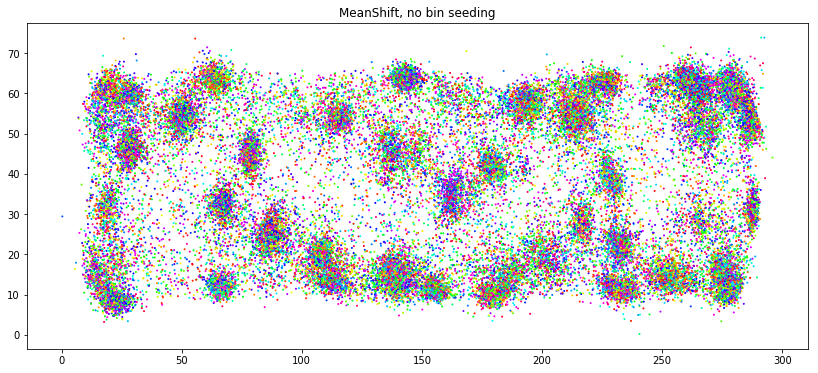

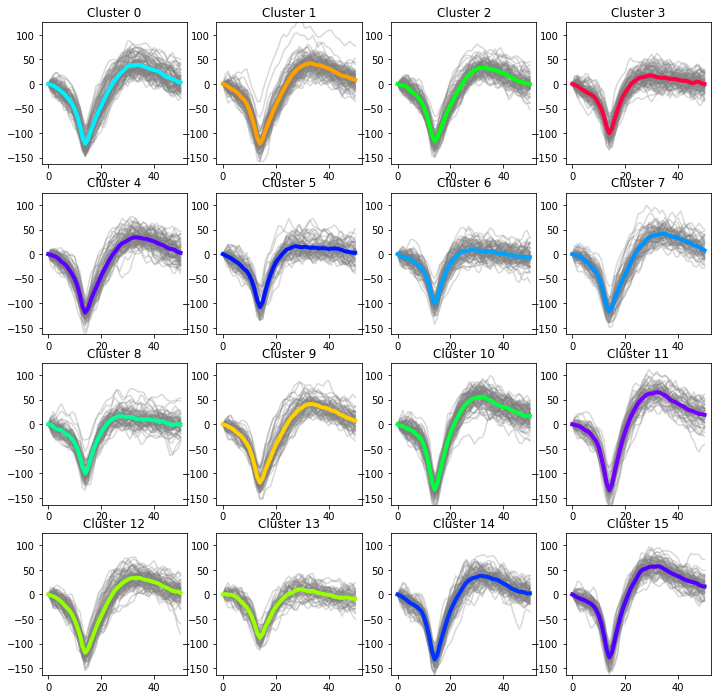

In [44]:
get_cluster(0.25)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    4.2s remaining:   12.6s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    4.8s remaining:    1.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    4.9s finished


Number of estimated units: 27860


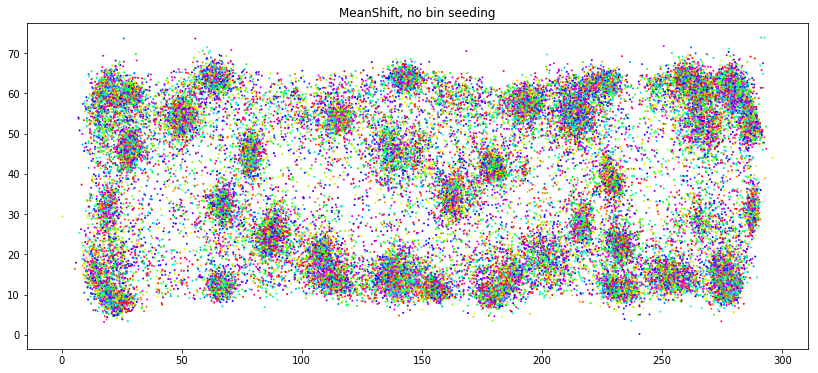

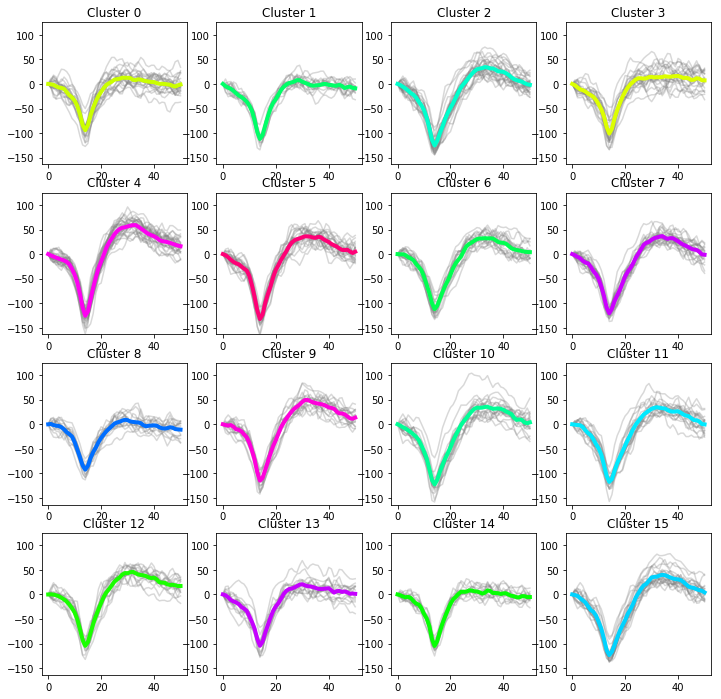

In [45]:
get_cluster(0.5)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    3.0s remaining:    9.1s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    3.5s remaining:    0.7s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    3.7s finished


Number of estimated units: 39060


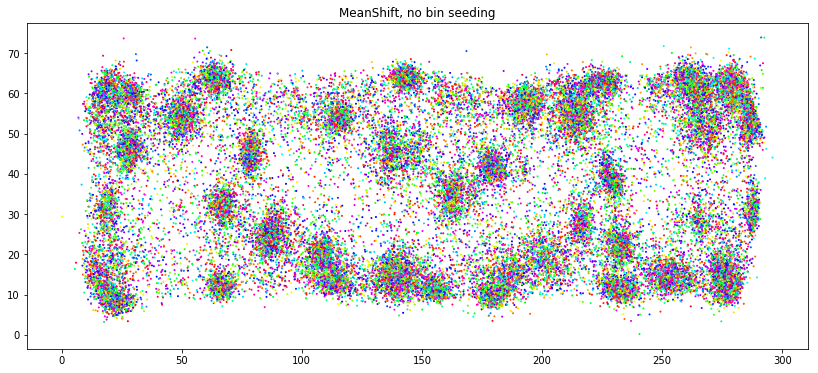

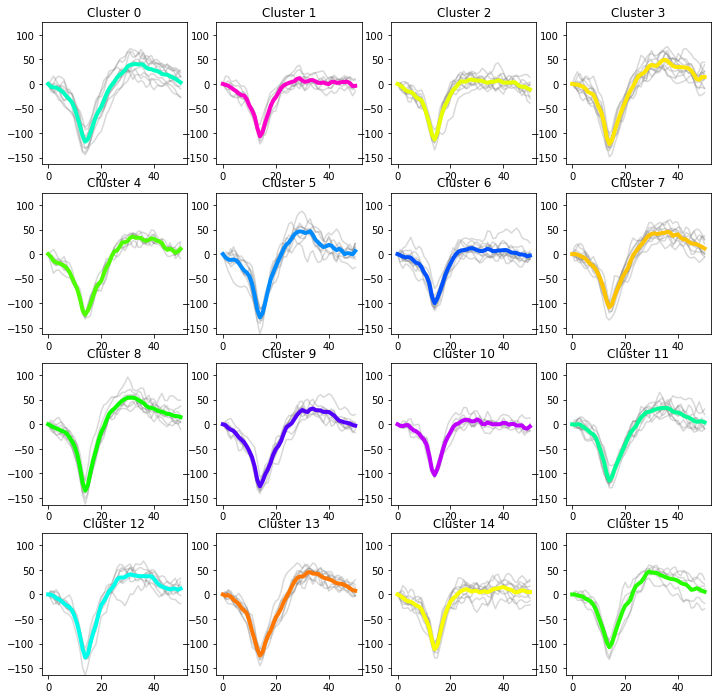

In [46]:
get_cluster(1)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 48009 spikes...
number of seeds: 48009
seeds/job: 4001
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    2.6s remaining:    7.7s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    3.0s remaining:    0.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    3.2s finished


Number of estimated units: 45284


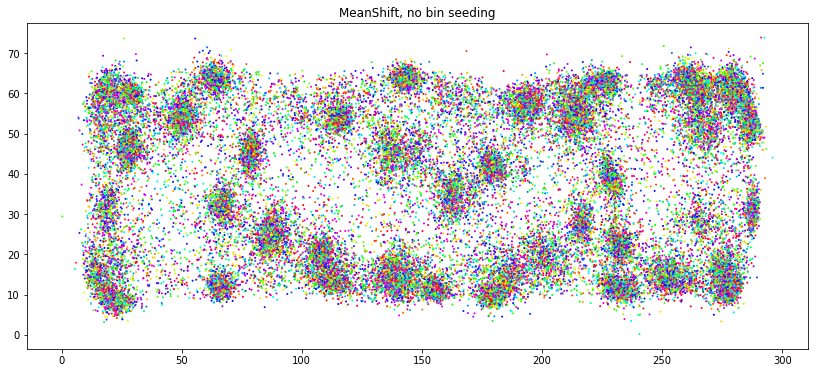

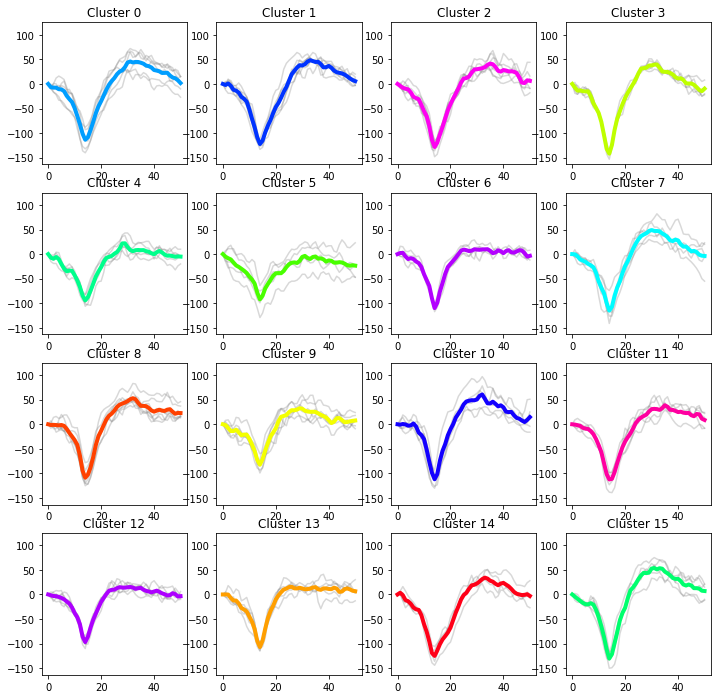

In [47]:
get_cluster(2)

units = range(16)
C.PlotShapes(units)